# **Mental Health in Tech — Advanced & Tuned Notebook**
**Project Goal:** Predict whether an employee seeks mental health treatment based on survey responses.

**Methodology:** This notebook employs an advanced workflow, including:
1.  Robust preprocessing for mixed data types (numeric, ordinal, nominal, and text).
2.  Feature engineering to create more predictive features.
3.  Simultaneous hyperparameter tuning of multiple models (Logistic Regression, Random Forest, XGBoost) using `RandomizedSearchCV`.
4.  Evaluation and comparison of the best-performing models.
5.  Feature importance extraction for model interpretability.

## 1. Environment Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score, f1_score
)

# Google Colab
from google.colab import drive

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/ML PROJECT SLP LAB/survey.csv'

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()

print(f"Loaded {df.shape[0]} rows, {df.shape[1]} columns.")
df.head()


Mounted at /content/drive
Loaded 1259 rows, 27 columns.


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


## 2. Preprocessing & Feature Engineering

In [3]:
# 2.1. Initial Column Dropping and Data Type Conversion
df = df.drop(columns=['Timestamp', 'state'], errors='ignore')

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df[(df['Age'] > 18) & (df['Age'] < 75)]


In [4]:
# 2.2. Clean 'Gender' Column
def clean_gender(x):
    if pd.isna(x): return "Other"
    s = str(x).lower().strip()
    if 'female' in s or s in ['f','woman','cis-female']: return 'Female'
    if 'male' in s or s in ['m','man','cis-male']: return 'Male'
    return 'Other'

df['Gender'] = df['Gender'].apply(clean_gender)


In [5]:
# 2.3. Impute Missing Categorical Data
for col in ['self_employed', 'work_interfere']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])


In [6]:
# 2.4. Preserve 'comments' for NLP
if 'comments' in df.columns:
    df['comments_text'] = df['comments'].fillna("None")
    df = df.drop(columns=['comments'])


In [7]:
# 2.5. Feature Engineering
# Age Groups
age_bins = [18, 25, 35, 45, 55, 65, 75]
age_labels = ['18-24','25-34','35-44','45-54','55-64','65-74']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Reduce countries
top_countries = df['Country'].value_counts().nlargest(5).index
df['Country_reduced'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Remote work flag
df['remote_work_flag'] = df['remote_work'].apply(lambda x: 1 if str(x).lower().strip()=="yes" else 0)

print("Feature engineering complete.")


Feature engineering complete.


## 3. Prepare Data for Modeling

In [8]:
# 3.1. Define Features (X) and Target (y)
target = 'treatment'
drop_cols = ['Age','Country','remote_work',target]

X = df.drop(columns=drop_cols)
y = df[target].map({'Yes':1, 'No':0})


In [9]:
# 3.2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)


(933, 24) (311, 24)


In [10]:
# 3.3. Check for Class Imbalance
y_train.value_counts(normalize=True)


,proportion
treatment,
1,0.505895
0,0.494105


**Observation:**

The target classes are almost perfectly balanced (approx. 51% vs 49%).

Therefore, using SMOTE (Synthetic Minority Over-sampling Technique) is **unnecessary** and could potentially harm performance by adding noise. We will proceed without it.

We will still use `class_weight='balanced'` as a tuning parameter, as it's a good practice, but heavy-duty oversampling is not required.
  

In [11]:
# 3.4. Define Preprocessing Pipelines for Mixed Data Types
numeric_cols = ['remote_work_flag']
ordinal_cols = ['Age_Group']
text_cols = ['comments_text']

# Get all other categorical columns for One-Hot Encoding
categorical_cols = X_train.select_dtypes(include=['object','category']).columns
ohe_cols = [c for c in categorical_cols if c not in ordinal_cols and c not in text_cols]

print(f"Numeric cols: {numeric_cols}")
print(f"Ordinal cols: {ordinal_cols}")
print(f"Text cols: {text_cols}")
print(f"OHE cols: {ohe_cols}")

# Create pipelines for each data type
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[age_labels]))
])

text_transformer = TfidfVectorizer(max_features=100, stop_words='english')

ohe_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers into a single preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('ord', ordinal_transformer, ordinal_cols),
    ('text', text_transformer, text_cols[0]),
    ('ohe', ohe_transformer, ohe_cols)
])


Numeric cols: ['remote_work_flag']
Ordinal cols: ['Age_Group']
Text cols: ['comments_text']
OHE cols: ['Gender', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'Country_reduced']


## 4. Model Training & Hyperparameter Tuning

In [12]:
# 4.1. Define the Main Pipeline and Parameter Grid for Tuning
main_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', None)
])


In [13]:
param_grid = [
    {
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__C': np.logspace(-3, 2, 6),
        'clf__penalty': ['l1','l2'],
        'clf__class_weight': [None,'balanced']
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None,10,20,30],
        'clf__min_samples_split': [2,5,10],
        'clf__min_samples_leaf': [1,2,4],
        'clf__class_weight': [None,'balanced']
    },
    {
        'clf': [xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'clf__n_estimators': [100,200,300],
        'clf__learning_rate': [0.01,0.1,0.2],
        'clf__max_depth': [3,5,7]
    }
]


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    main_pipeline,
    param_distributions=param_grid,
    n_iter=15,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['remote_work_flag']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)],
                                         'clf__learning_rate': [0.01, 0.1, 0.2],
                                         'clf__max_depth': [3, 5, 7],
                                         'clf__n_estimators': [100, 200, 300]}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [15]:
# 4.2. Display Tuning Results
print(f"Best Model: {search.best_estimator_.named_steps['clf'].__class__.__name__}")
print(f"Best ROC AUC Score: {search.best_score_:.4f}")
print("Best Parameters:")
print(search.best_params_)

Best Model: RandomForestClassifier
Best ROC AUC Score: 0.8075
Best Parameters:
{'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_depth': 10, 'clf__class_weight': 'balanced', 'clf': RandomForestClassifier()}


## 5. Evaluate Best Model

In [16]:
# 5.1. Evaluate the single best model from the search on the test set
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 0.7427652733118971
F1: 0.738562091503268
ROC AUC: 0.8234345272561834
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       154
           1       0.76      0.72      0.74       157

    accuracy                           0.74       311
   macro avg       0.74      0.74      0.74       311
weighted avg       0.74      0.74      0.74       311



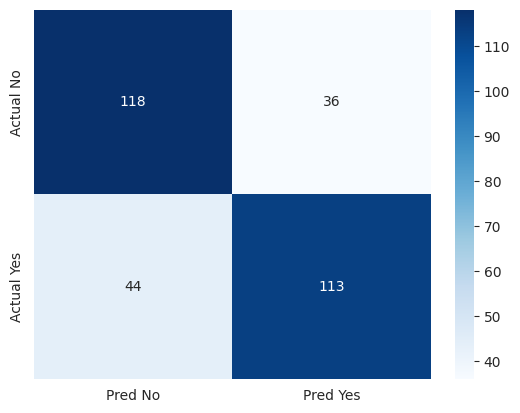

In [17]:
# 5.2. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred No','Pred Yes'],
            yticklabels=['Actual No','Actual Yes'])
plt.show()


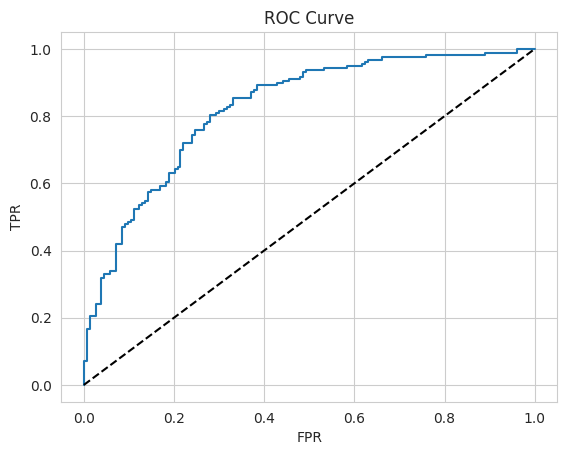

In [18]:
# 5.3. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()


## 6. Model Comparison and Feature Importance

In [19]:
# 6.1. Display Full Results from RandomizedSearchCV

# This table shows the performance of all model types and parameters tested\n",
cv_results_df = pd.DataFrame(search.cv_results_)
cols_to_show = ['param_clf', 'mean_test_score', 'std_test_score', 'rank_test_score']

print("--- Model Tuning Comparison (Ranked by ROC AUC) ---")
display(cv_results_df[cols_to_show].sort_values(by='rank_test_score'))

--- Model Tuning Comparison (Ranked by ROC AUC) ---


,param_clf,mean_test_score,std_test_score,rank_test_score
14,RandomForestClassifier(),0.807549,0.016382,1
8,RandomForestClassifier(),0.806892,0.015255,2
3,RandomForestClassifier(),0.806793,0.017969,3
9,RandomForestClassifier(),0.805399,0.023691,4
0,RandomForestClassifier(),0.804389,0.017268,5
2,RandomForestClassifier(),0.804215,0.019790,6
5,RandomForestClassifier(),0.803829,0.013236,7
1,RandomForestClassifier(),0.803773,0.019900,8
4,RandomForestClassifier(),0.803326,0.019647,9
6,RandomForestClassifier(),0.803121,0.016380,10


In [20]:
# 6.2. Helper Function to Get Feature Names from Preprocessor
def get_feature_names_from_coltransformer(ct):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder': continue
        if isinstance(trans, Pipeline):
            trans = trans.steps[-1][1]
        if hasattr(trans,'get_feature_names_out'):
            names.extend(trans.get_feature_names_out(cols if isinstance(cols,list) else None))
        else:
            names.extend(cols)
    return names

feature_names = get_feature_names_from_coltransformer(best_model.named_steps['preprocessor'])


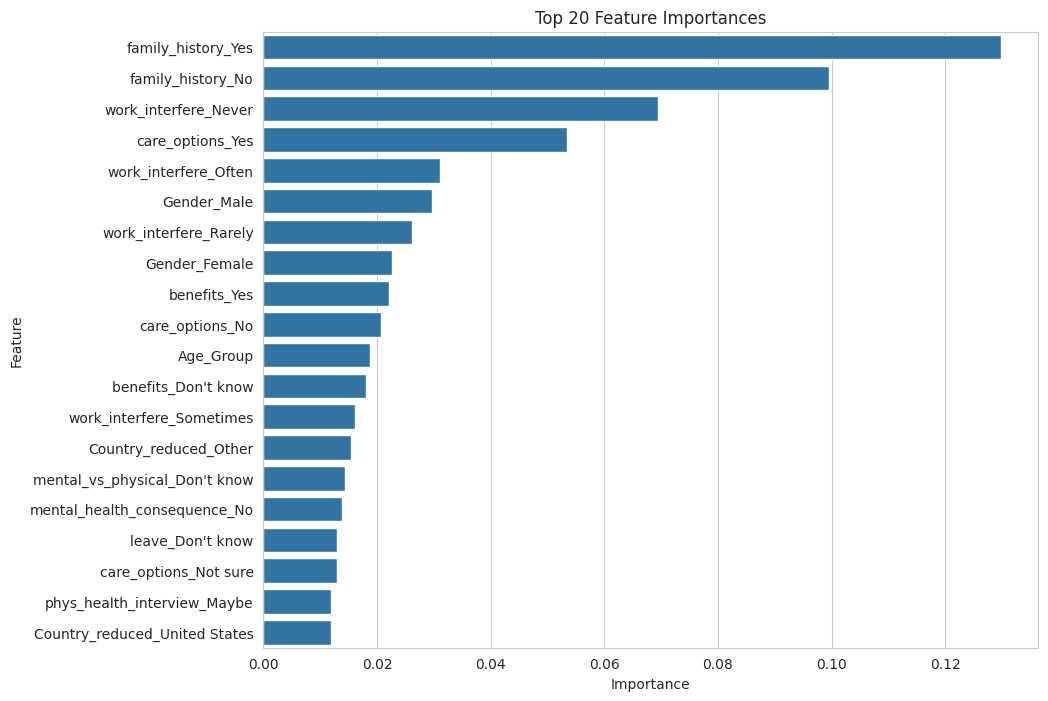

In [21]:
# 6.3. Plot Feature Importances
clf = best_model.named_steps['clf']

if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
elif hasattr(clf, 'coef_'):
    importances = np.abs(clf.coef_[0])
else:
    importances = None

if importances is not None:
    fi = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi = fi.sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(10,8))
    sns.barplot(data=fi, y='Feature', x='Importance')
    plt.title("Top 20 Feature Importances")
    plt.show()


## 7. Conclusion
    
This notebook successfully built and evaluated several models to predict the need for mental health treatment.

1.  **Data Preprocessing:** A robust pipeline was created to handle numeric, ordinal, nominal (OHE), and text (TF-IDF) data simultaneously.

2.  **Imbalance:** The target class was found to be well-balanced, so SMOTE was not used.

3.  **Model Selection:** `RandomizedSearchCV` was used to tune and compare Logistic Regression, Random Forest, and XGBoost.

4.  **Performance:** The best model was identified based on the cross-validated ROC AUC score. The final classification report, confusion matrix, and feature importances for this best model provide a comprehensive view of its performance and interpretability."
  